In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
!kaggle datasets download -d ahmedaboenaba/coronary-artery-angiograms-zip

Dataset URL: https://www.kaggle.com/datasets/ahmedaboenaba/coronary-artery-angiograms-zip
License(s): ODbL-1.0
coronary-artery-angiograms-zip.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip /content/coronary-artery-angiograms-zip.zip

Archive:  /content/coronary-artery-angiograms-zip.zip
  inflating: Datasets/stenosis/test/annotations/test.json  
  inflating: Datasets/stenosis/test/images/1.png  
  inflating: Datasets/stenosis/test/images/10.png  
  inflating: Datasets/stenosis/test/images/100.png  
  inflating: Datasets/stenosis/test/images/101.png  
  inflating: Datasets/stenosis/test/images/102.png  
  inflating: Datasets/stenosis/test/images/103.png  
  inflating: Datasets/stenosis/test/images/104.png  
  inflating: Datasets/stenosis/test/images/105.png  
  inflating: Datasets/stenosis/test/images/106.png  
  inflating: Datasets/stenosis/test/images/107.png  
  inflating: Datasets/stenosis/test/images/108.png  
  inflating: Datasets/stenosis/test/images/109.png  
  inflating: Datasets/stenosis/test/images/11.png  
  inflating: Datasets/stenosis/test/images/110.png  
  inflating: Datasets/stenosis/test/images/111.png  
  inflating: Datasets/stenosis/test/images/112.png  
  inflating: Datasets/stenosis/test/images

In [3]:
import os

folder = "/content/Datasets/stenosis/"
count = 1

for filename in os.listdir(folder):
  if filename.endswith(".jpg") or filename.endswith(".png"):
    source = os.path.join(folder, filename)
    destination = os.path.join(folder, "Y_" + str(count) + ".jpg")
    try:
      os.rename(source, destination)
      count += 1
    except FileNotFoundError:
      print(f"File not found: {source}")
print("All files are renamed in the yes dir.")



All files are renamed in the yes dir.


In [4]:
listyes = os.listdir("/content/Datasets/stenosis/test/images")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("/content/Datasets/syntax/test/images")
number_files_no = len(listno)
print(number_files_no)

300
300


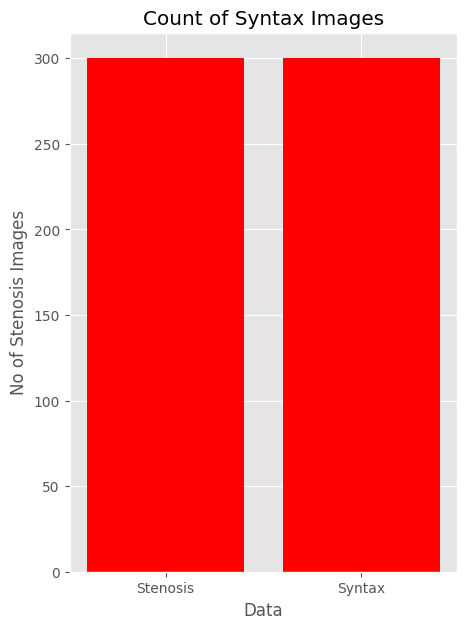

In [5]:

data = {'Stenosis': number_files_yes, 'Syntax': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Stenosis Images")
plt.title("Count of Syntax Images")
plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [53]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [54]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)

    data_gen = ImageDataGenerator(
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image_path = os.path.join(file_dir, filename)
        image = cv2.imread(image_path)
        if image is not None:  # Check if the image was loaded successfully
            image = image.reshape((1,) + image.shape)
            save_prefix = 'aug_' + filename[:-4]
            i=0
            for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
                i+=1
                if i>n_generated_samples:
                    break
        else:
            print(f"Could not load image: {image_path}")


In [12]:
yes_path = '/content/Datasets/stenosis/test/images'
no_path = '/content/Datasets/stenosis/test/images'
augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')


In [52]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/"
    no_path = "augmented_data/no/"

    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))

    n = (n_pos + n_neg)

    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n

    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [12]:
data_summary(augmented_data_path)

NameError: name 'augmented_data_path' is not defined

In [50]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

2099
2999


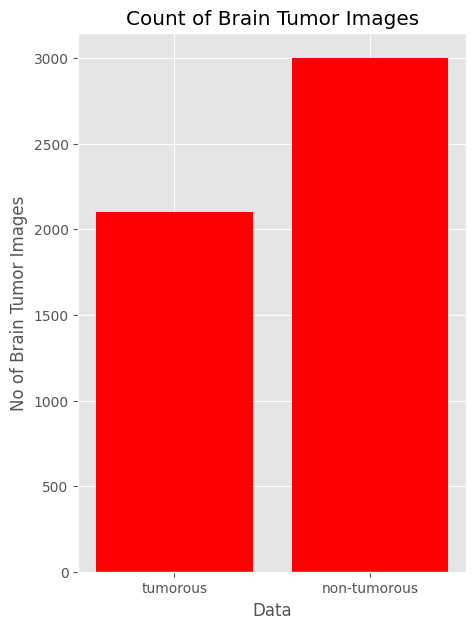

In [51]:
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

In [12]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)

    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)

    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image


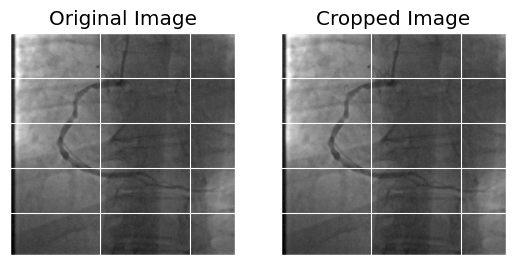

array([[[ 39,  39,  39],
        [ 40,  40,  40],
        [ 39,  39,  39],
        ...,
        [  3,   3,   3],
        [  1,   1,   1],
        [  0,   0,   0]],

       [[ 46,  46,  46],
        [ 46,  46,  46],
        [ 44,  44,  44],
        ...,
        [ 28,  28,  28],
        [ 24,  24,  24],
        [ 23,  23,  23]],

       [[ 42,  42,  42],
        [ 41,  41,  41],
        [ 41,  41,  41],
        ...,
        [ 64,  64,  64],
        [ 60,  60,  60],
        [ 58,  58,  58]],

       ...,

       [[  2,   2,   2],
        [  3,   3,   3],
        [  2,   2,   2],
        ...,
        [106, 106, 106],
        [104, 104, 104],
        [102, 102, 102]],

       [[  2,   2,   2],
        [  2,   2,   2],
        [  1,   1,   1],
        ...,
        [105, 105, 105],
        [103, 103, 103],
        [102, 102, 102]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [106, 106, 106],
        [104, 104, 104],
        [101, 101, 101]]], dtype=uint8)
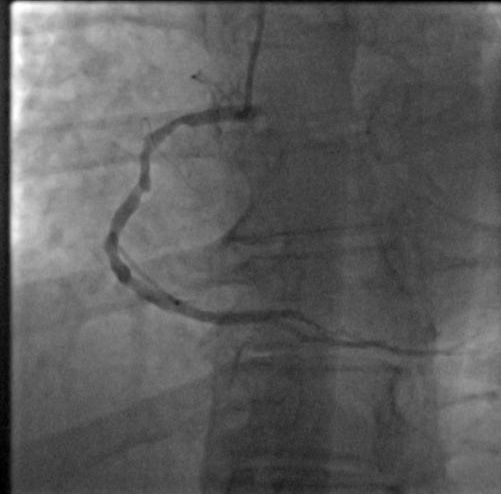

In [13]:
img = cv2.imread('/content/augmented_data/yes/aug_101_0_4686.jpg')
crop_brain_tumor(img, True)

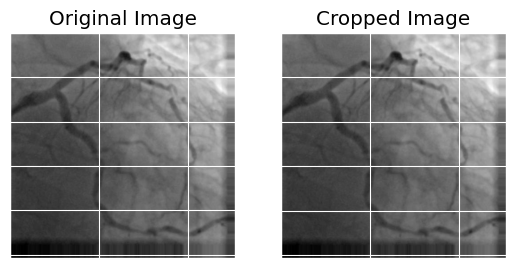

array([[[125, 125, 125],
        [125, 125, 125],
        [125, 125, 125],
        ...,
        [143, 143, 143],
        [143, 143, 143],
        [143, 143, 143]],

       [[124, 124, 124],
        [124, 124, 124],
        [125, 125, 125],
        ...,
        [142, 142, 142],
        [142, 142, 142],
        [142, 142, 142]],

       [[123, 123, 123],
        [123, 123, 123],
        [124, 124, 124],
        ...,
        [142, 142, 142],
        [142, 142, 142],
        [142, 142, 142]],

       ...,

       [[  8,   8,   8],
        [  6,   6,   6],
        [  3,   3,   3],
        ...,
        [ 57,  57,  57],
        [ 57,  57,  57],
        [ 57,  57,  57]],

       [[  8,   8,   8],
        [  6,   6,   6],
        [  3,   3,   3],
        ...,
        [ 57,  57,  57],
        [ 57,  57,  57],
        [ 57,  57,  57]],

       [[  8,   8,   8],
        [  6,   6,   6],
        [  3,   3,   3],
        ...,
        [ 57,  57,  57],
        [ 57,  57,  57],
        [ 57,  57,  57]]], dtype=uint8)
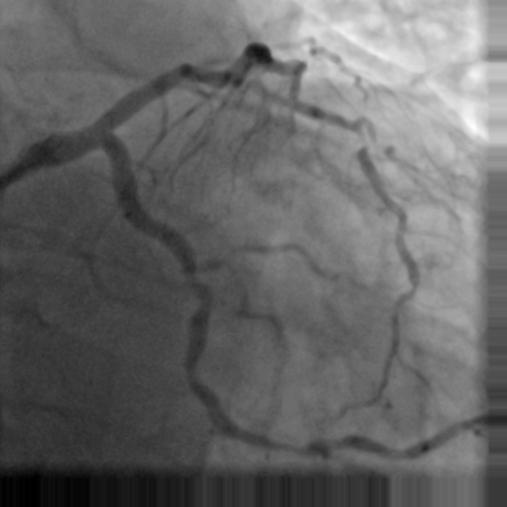

In [14]:
img = cv2.imread('/content/augmented_data/no/aug_107_0_2988.jpg')
crop_brain_tumor(img, True)

In [15]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [1]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y


In [16]:
augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (128,128)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 5098
X SHAPE is : (5098, 128, 128, 3)
y SHAPE is : (5098,)


In [17]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Cortories Diseases: {label_to_str(label)}")
        plt.show()

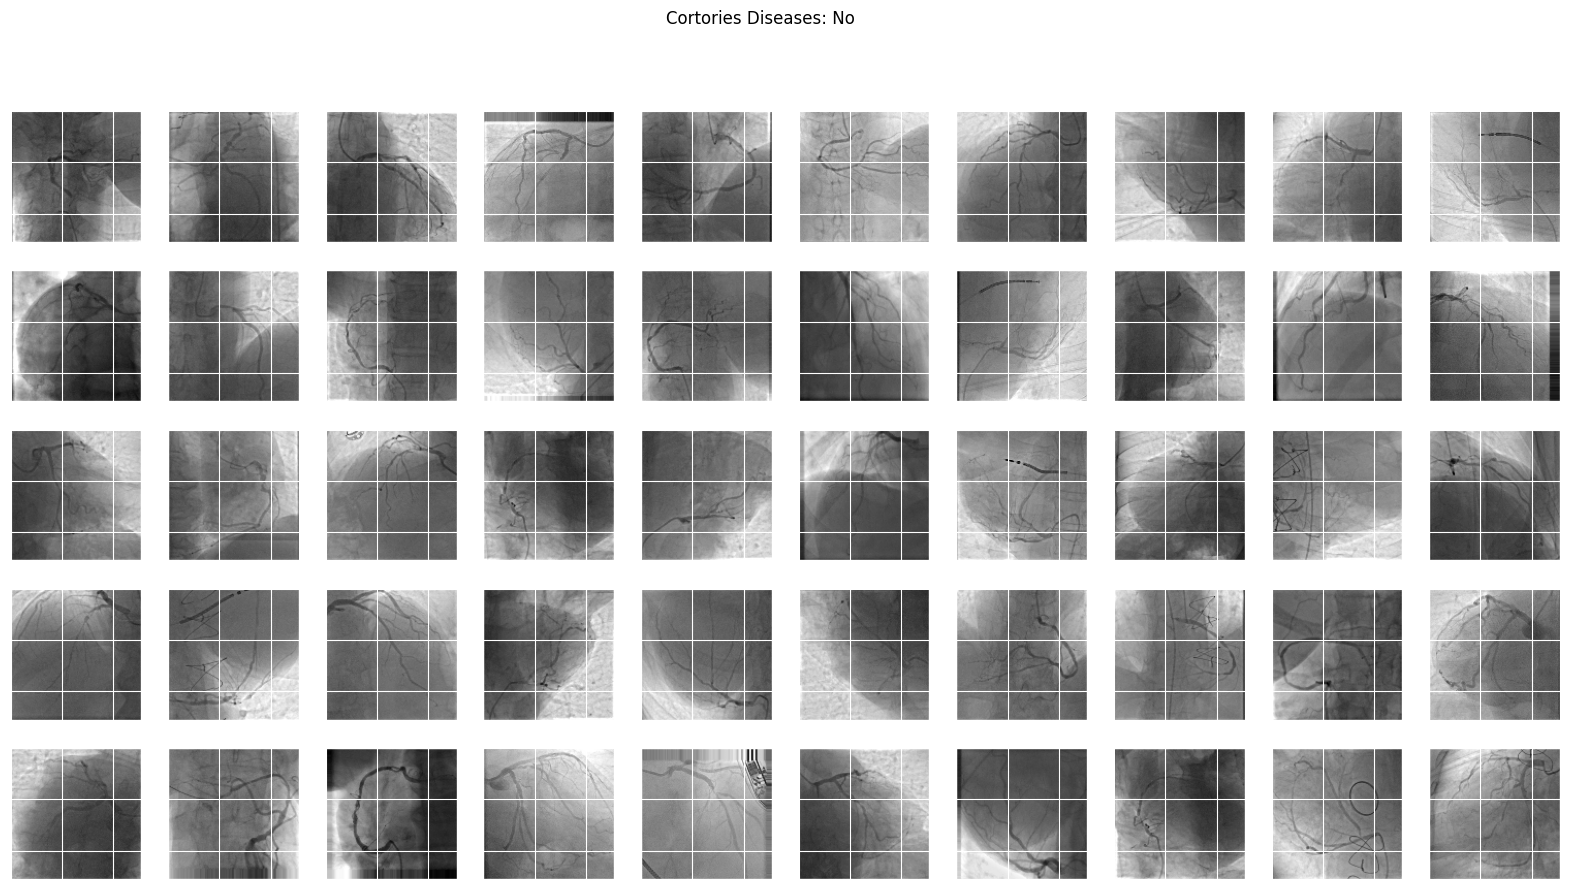

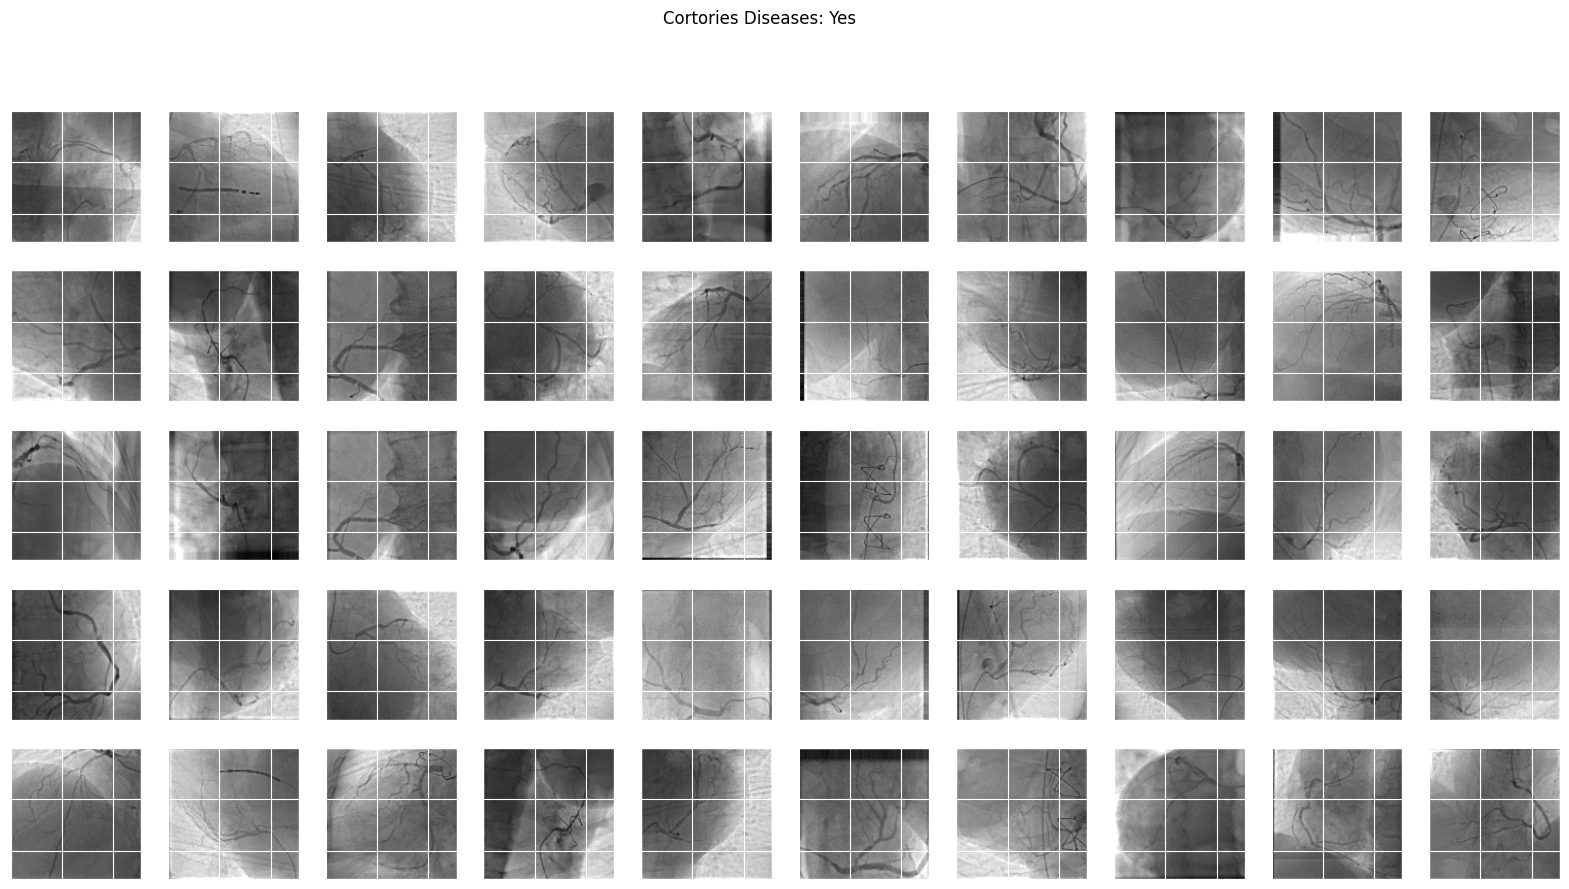

In [18]:
plot_sample_images(X,y)

In [19]:
if not os.path.isdir('stenosis_and_syntax'):
    base_dir = 'stenosis_and_syntax'
    os.mkdir(base_dir)

In [20]:
if not os.path.isdir('stenosis_and_syntax/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('stenosis_and_syntax/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('stenosis_and_syntax/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [21]:
if not os.path.isdir('stenosis_and_syntax/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('stenosis_and_syntax/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('stenosis_and_syntax/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [22]:
if not os.path.isdir('stenosis_and_syntax/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('stenosis_and_syntax/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('stenosis_and_syntax/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [23]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [24]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [25]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [26]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(922,1085):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [27]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [28]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [29]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833,979):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

In [30]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [31]:
train_generator = train_datagen.flow_from_directory('stenosis_and_syntax/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 1445 images belonging to 2 classes.


In [32]:
test_generator = train_datagen.flow_from_directory('stenosis_and_syntax/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 310 images belonging to 2 classes.


In [33]:
valid_generator = train_datagen.flow_from_directory('stenosis_and_syntax/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')


Found 309 images belonging to 2 classes.


In [34]:
class_labels = train_generator.class_indices
class_name = {value: key for (key,value) in class_labels.items()}

In [35]:
class_name

{0: 'nontumorous', 1: 'tumorous'}

In [36]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [42]:
filepath = 'model.keras'  # Change to .keras extension
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)


In [40]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [43]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.4758 - loss: 0.7330 
Epoch 1: val_loss improved from inf to 0.73100, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 618s 64s/step - accuracy: 0.4787 - loss: 0.7354 - val_accuracy: 0.5275 - val_loss: 0.7310 - learning_rate: 1.0000e-04
Epoch 2/2


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.4869 - loss: 0.7190 
Epoch 2: val_loss improved from 0.73100 to 0.70564, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 626s 66s/step - accuracy: 0.4867 - loss: 0.7202 - val_accuracy: 0.5340 - val_loss: 0.7056 - learning_rate: 1.0000e-04


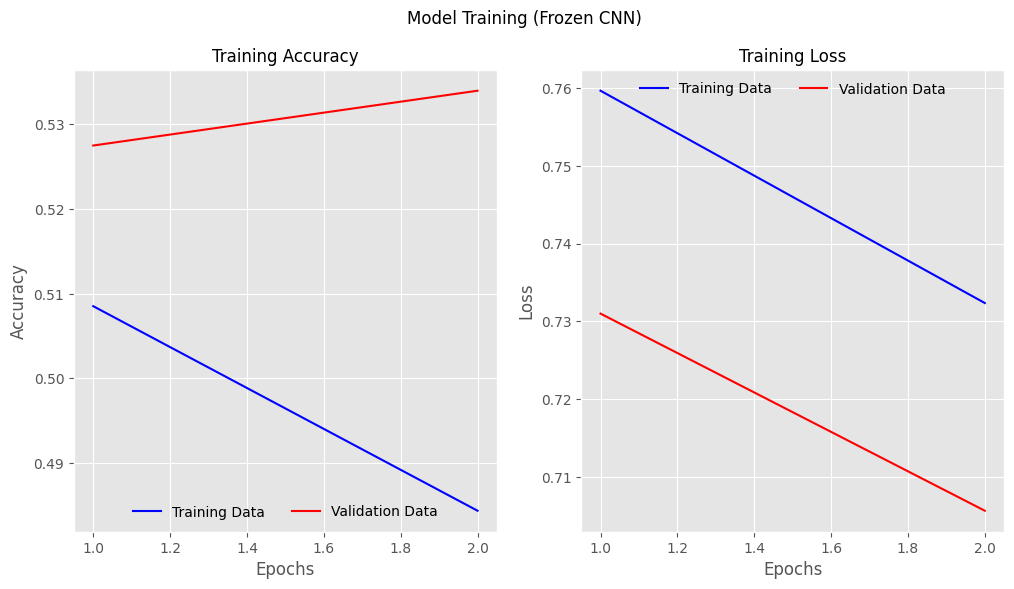

In [44]:
# Plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
max_epoch = len(history_01.history['accuracy'])+1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='upper center', ncol=2)
plt.savefig("training_frozencnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

In [74]:
images_path = "/content/Datasets"
annotations_path = "/content/Datasets/stenosis/test/annotations/test.json"

Train: 1000
Validation: 1000
Classes: 1


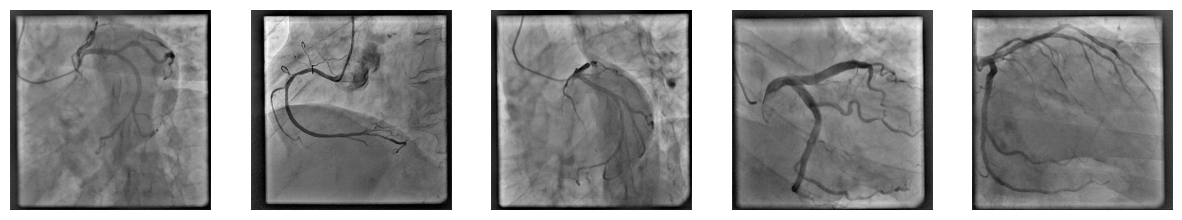

In [97]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class load_image_dataset:
    def __init__(self, annotations_path, images_path, dataset_type):
        self.annotations_path = annotations_path
        self.images_path = images_path
        self.dataset_type = dataset_type

        try:
            with open(self.annotations_path, 'r') as f:
                self.annotations = json.load(f)
            self.image_ids = self.annotations["images"]  # Store image metadata directly
        except FileNotFoundError:
            print(f"File not found: {self.annotations_path}")
            self.image_ids = []
            self.annotations = {}

    def count_classes(self):
        classes = set()
        if self.annotations and 'annotations' in self.annotations:
            for annotation in self.annotations['annotations']:
                classes.add(annotation["category_id"])
        return len(classes)

# Define the annotations path
annotations_path = "/content/Datasets/stenosis/train/annotations/train.json"

# Create dataset objects
dataset_train = load_image_dataset(annotations_path, "/content/Datasets/stenosis/train/images", "train")
dataset_val = load_image_dataset(annotations_path, "/content/Datasets/stenosis/val/images", "val")

# Get the number of classes
class_number = dataset_train.count_classes()

# Output dataset information
print('Train: %d' % len(dataset_train.image_ids))
print('Validation: %d' % len(dataset_val.image_ids))
print("Classes: {}".format(class_number))

# Function to display image samples
def display_image_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, image_info in enumerate(dataset.image_ids[:num_samples]):
        image_file_name = image_info["file_name"]  # Extract file name from image_info
        image_path = os.path.join(dataset.images_path, image_file_name)  # Build full path
        img = mpimg.imread(image_path)  # Read the image
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Display samples from the training dataset
display_image_samples(dataset_train)


In [126]:
class InferenceConfig:
    # Add necessary inference parameters here
    # Example parameter
    confidence_threshold = 0.5  # Example of a configuration parameter for inference

# Function to test a random image from the validation dataset
def test_random_image(model, dataset_val, inference_config):
    random_image_info = random.choice(dataset_val.image_ids)
    image_file_name = random_image_info["file_name"]
    image_path = os.path.join(dataset_val.images_path, image_file_name)

    original_image = mpimg.imread(image_path)
    print(f"Original Image shape: {original_image.shape}, min: {original_image.min()}, max: {original_image.max()}")

    # Process the image using the model
    molded_image = model.test(original_image)

    print(f"Trained model result")
    print(f"Processed image shape: {molded_image.shape}, min: {molded_image.min()}, max: {molded_image.max()}")

Train: 1000
Validation: 1000
Classes: 1


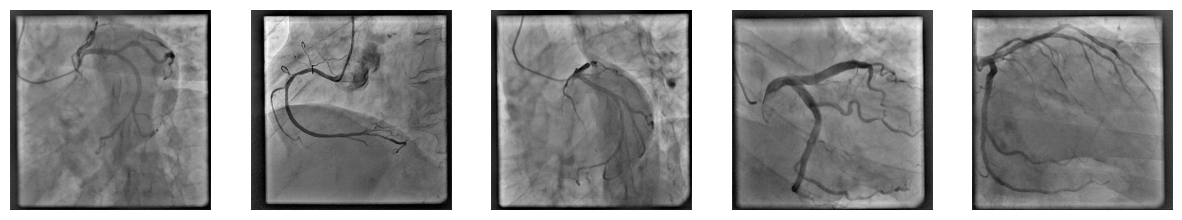

Training model head with config: Your CAD Kernel Config
Training with learning rate: 0.001, epochs: 7, layers: heads
Model training completed.
Original Image shape: (512, 512), min: 0.0, max: 1.0
Trained model result
Processed image shape: (512, 512), min: -123.7, max: -122.7


In [132]:
import os
import json
import random  # Ensure random is imported
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load image dataset class
class load_image_dataset:
    def __init__(self, annotations_path, images_path, dataset_type):
        self.annotations_path = annotations_path
        self.images_path = images_path
        self.dataset_type = dataset_type

        try:
            with open(self.annotations_path, 'r') as f:
                self.annotations = json.load(f)
            self.image_ids = self.annotations["images"]
        except FileNotFoundError:
            print(f"File not found: {self.annotations_path}")
            self.image_ids = []
            self.annotations = {}

    def count_classes(self):
        classes = set()
        if self.annotations and 'annotations' in self.annotations:
            for annotation in self.annotations['annotations']:
                classes.add(annotation["category_id"])
        return len(classes)

# Function to display image samples
def display_image_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, image_info in enumerate(dataset.image_ids[:num_samples]):
        image_file_name = image_info["file_name"]
        image_path = os.path.join(dataset.images_path, image_file_name)
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Dummy model class for illustration
class YourModelClass:
    def train(self, dataset_train, dataset_val, learning_rate, epochs, layers):
        print(f"Training with learning rate: {learning_rate}, epochs: {epochs}, layers: {layers}")

    def test(self, image):
        # Simulated result of processing the image
        processed_image = (image.astype(np.float64) - 123.7)  # Example normalization
        return processed_image

# Inference configuration class
class InferenceConfig:
    # Add necessary inference parameters here
    # Example parameter
    confidence_threshold = 0.5  # Example of a configuration parameter for inference

# Function to test a random image from the validation dataset
def test_random_image(model, dataset_val, inference_config):
    random_image_info = random.choice(dataset_val.image_ids)
    image_file_name = random_image_info["file_name"]
    image_path = os.path.join(dataset_val.images_path, image_file_name)

    original_image = mpimg.imread(image_path)
    print(f"Original Image shape: {original_image.shape}, min: {original_image.min()}, max: {original_image.max()}")

    # Process the image using the model
    molded_image = model.test(original_image)

    print(f"Trained model result")
    print(f"Processed image shape: {molded_image.shape}, min: {molded_image.min()}, max: {molded_image.max()}")

# Main execution flow
if __name__ == "__main__":
    annotations_path = "/content/Datasets/stenosis/train/annotations/train.json"

    dataset_train = load_image_dataset(annotations_path, "/content/Datasets/stenosis/train/images", "train")
    dataset_val = load_image_dataset(annotations_path, "/content/Datasets/stenosis/val/images", "val")

    class_number = dataset_train.count_classes()
    print('Train: %d' % len(dataset_train.image_ids))
    print('Validation: %d' % len(dataset_val.image_ids))
    print("Classes: {}".format(class_number))

    display_image_samples(dataset_train)

    model = YourModelClass()

    # Train the model
    def train_head(model, dataset_train, dataset_val, config):
        print("Training model head with config:", config.CAD_KERNEL)
        model.train(
            dataset_train,
            dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=7,
            layers='heads'
        )
        print("Model training completed.")

    train_head(model, dataset_train, dataset_val, Config())

    # Create an inference config object
    inference_config = InferenceConfig()

    # Test a random image from the validation dataset
    test_random_image(model, dataset_val, inference_config)


In [137]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image

# Load the Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Load an image to test the model
image_path = "/content/Datasets/stenosis/train/images/1.png"  # Update with your image path
image = Image.open(image_path)

# Transform the image to the format required by the model
image_tensor = F.to_tensor(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    predictions = model(image_tensor)

# Print predictions
print(predictions)


[{'boxes': tensor([[  5.6636,  22.3266, 447.5821, 488.5564],
        [167.8061, 101.6293, 417.2697, 463.1977],
        [ 23.3121,   1.3814, 501.6684, 512.0000],
        [181.0190,  39.9437, 396.1512, 483.8633],
        [ 35.1598,  10.8562, 496.1433, 502.2958],
        [177.2955,  21.8493, 253.3771, 212.2504],
        [147.1699,  29.0843, 437.4586, 468.8051],
        [155.6715,  35.1947, 438.1641, 466.2782],
        [143.3919,  20.6646, 458.9010, 443.1931],
        [149.2304,  26.8948, 442.7864, 465.9962],
        [ 45.4090,  37.4510, 467.0265, 456.7889],
        [ 11.3863,  30.4547, 224.2580, 448.6533]]), 'labels': tensor([ 1, 62, 65,  1, 63,  1, 33, 31, 28, 27, 62,  1]), 'scores': tensor([0.6021, 0.5005, 0.1740, 0.0864, 0.0766, 0.0698, 0.0687, 0.0652, 0.0571,
        0.0564, 0.0558, 0.0549])}]


Predictions:
Boxes: tensor([[ 13.9919,  24.9119, 454.0000, 491.3827],
        [ 24.8239, 150.1904, 381.2516, 435.4290]])
Scores: tensor([0.7905, 0.0820])
Labels: tensor([65,  1])


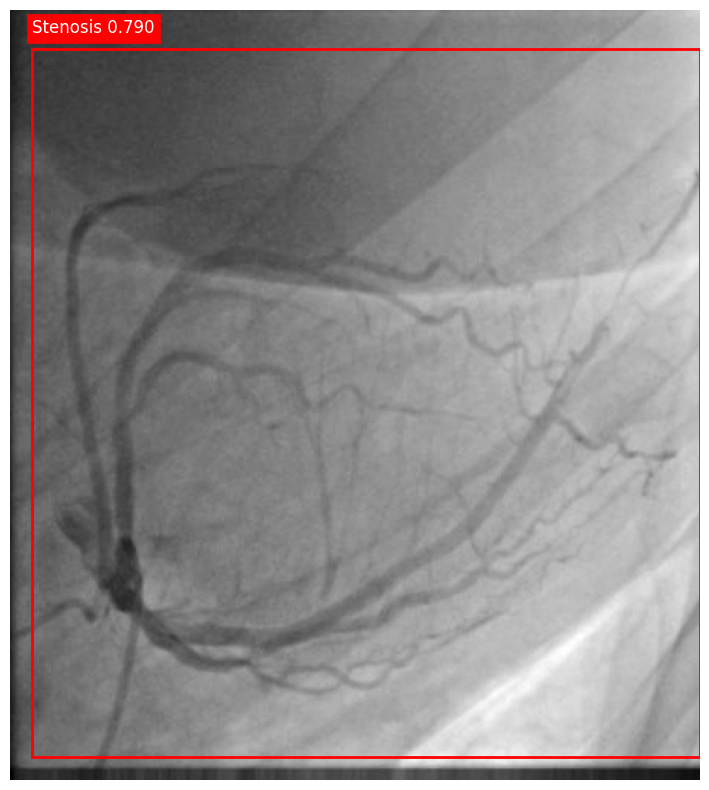

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T

# Load the Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Function to process the image and perform inference
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    return transform(image)

# Function to visualize detections
def visualize(image_path, predictions, threshold=0.2):  # Lowered threshold for better debugging
    image = np.array(Image.open(image_path).convert('L'))
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image, cmap='gray')

    # Get image dimensions
    img_h, img_w = image.shape

    # Draw bounding boxes and labels for predictions
    for box, score, label in zip(predictions['boxes'], predictions['scores'], predictions['labels']):
        x_min, y_min, x_max, y_max = box.cpu().numpy()

        # Clip boxes to be within the image dimensions
        x_min, y_min, x_max, y_max = max(0, x_min), max(0, y_min), min(img_w, x_max), min(img_h, y_max)

        # Drawing red bounding box for stenosis and blue for non-stenosis
        if score > threshold:
            width, height = x_max - x_min, y_max - y_min
            if score >= 0.5:  # High score indicates stenosis
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                label_text = f'Stenosis {score:.3f}'
                ax.text(x_min, y_min - 10, label_text, color='white', fontsize=12, backgroundcolor='red')
            else:  # Lower score, possibly non-stenosis
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='b', facecolor='none')
                label_text = f'Non-Stenosis {score:.3f}'
                ax.text(x_min, y_min - 10, label_text, color='white', fontsize=12, backgroundcolor='blue')

            ax.add_patch(rect)

    plt.axis('off')  # Turn off axis numbers and ticks
    plt.tight_layout()
    plt.show()

# Load and prepare an image
image_path ="/content/augmented_data/yes/aug_119_0_4485.jpg"  # Replace with the correct image path
image_tensor = load_image(image_path)

# Perform inference
with torch.no_grad():
    predictions = model([image_tensor])[0]

# Print predictions to debug
print("Predictions:")
print("Boxes:", predictions['boxes'])
print("Scores:", predictions['scores'])
print("Labels:", predictions['labels'])

# Visualize results with a lower threshold for detection score
visualize(image_path, predictions, threshold=0.2)
